In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
from datasets import *

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import normalize
from PIL import Image
import os
import random

# Seed
SEED = 12
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0")

root_dir = "/data/datasets/ImageNet2012/"
train_dir = os.path.join(root_dir, "train")
val_dir = os.path.join(root_dir, "val")

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # ConeTransform(),
    # SRGB2LMS(), 
])

In [2]:
dataset, _, _, _ = get_imagenet_subsets(train_dir, num_classes=10, imgs_per_subset=1000, transform=transform, selected_classes=None)
# dataset, _ = get_iid_split(train=True, transform = transform)

In [3]:
dataloader1 = DataLoader(dataset, batch_size=100, shuffle=True)
images, _ = next(iter(dataloader1))

In [4]:
class ZCAWhitening:
    def __init__(self, gamma=1e-1):
        self.gamma = gamma
        self.mean = None
        self.ZCA_matrix = None

    def fit(self, input):
        X = input.reshape(input.shape[0], -1)

        # Compute the mean of the data
        self.mean = X.mean(dim=0)
        
        # Center the data
        X_norm = X - self.mean
        
        # Compute the covariance of the data
        cov = torch.mm(X_norm.T, X_norm) / (X_norm.size(0) - 1)
        
        # Perform eigenvalue decomposition
        U, S, V = torch.svd(cov)

        # Sort the eigenvalues and get the sorted indices
        sorted_indices = torch.argsort(S, descending=True)

        # Reorder the columns of U based on the sorted indices
        U_sorted = U[:, sorted_indices]

        # Recompute the ZCA whitening matrix
        self.ZCA_matrix = torch.mm(torch.mm(U_sorted, torch.diag(1.0 / torch.sqrt(S[sorted_indices] + self.gamma))), U_sorted.T)

#     def fit(self, input):
#         X = input.reshape(input.shape[0], -1)

#         # Compute the mean of the data
#         self.mean = X.mean(dim=0)
        
#         # Center the data
#         X_norm = X - self.mean
        
#         # Compute the covariance of the data
#         cov = torch.mm(X_norm.T, X_norm) / (X_norm.size(0) - 1)
        
#         # Perform eigenvalue decomposition
#         U, S, V = torch.svd(cov)
#         # Compute the ZCA whitening matrix

        self.ZCA_matrix = torch.mm(torch.mm(U, torch.diag(1.0/torch.sqrt(S + self.gamma))), U.T)
        
    def transform(self, input):
        X = input.reshape(input.shape[0], -1)
        X_centered = X - self.mean
        return torch.mm(self.ZCA_matrix, X.T).T.reshape(input.shape)


In [5]:
# 2. Chop images up into patches using unfold (similar to im2col)
patch_size = 16  # example patch size
patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
patches = patches.contiguous().view(-1, 3, patch_size, patch_size)
print(patches.shape)
[_, C, W, H] = patches.shape

torch.Size([19600, 3, 16, 16])


In [6]:
ZCA = ZCAWhitening(gamma=1e-2)
ZCA.fit(patches)

In [7]:
ZCA.ZCA_matrix.shape

torch.Size([768, 768])

In [8]:
num_filters = 147
filters = ZCA.ZCA_matrix[:num_filters].reshape(num_filters, C, W, H)

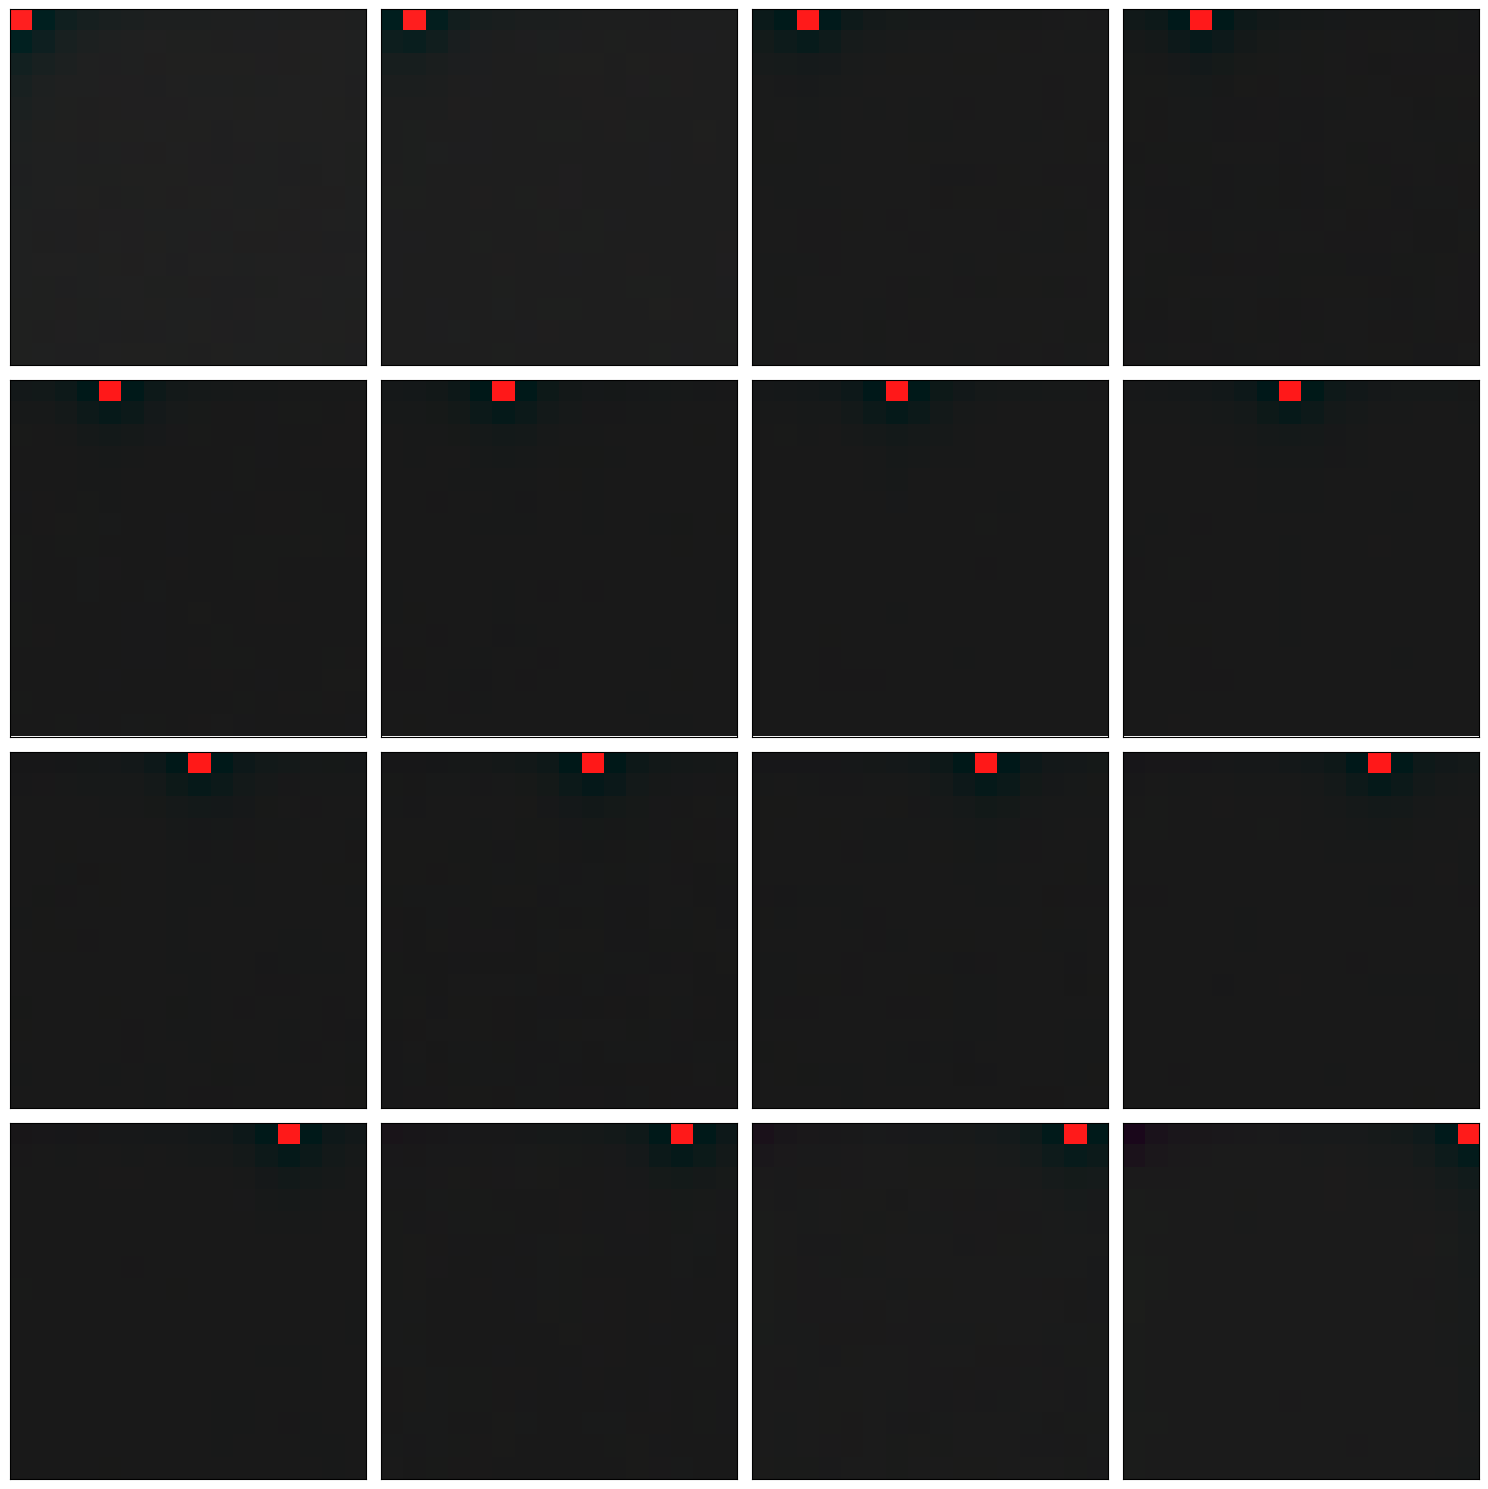

In [9]:
import matplotlib.pyplot as plt

# Assuming you have a list of 16 images stored in a variable called 'images'
# images = [img1, img2, img3, ..., img16]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    # Display image
    img = filters[i]
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img.permute(1,2,0))

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()

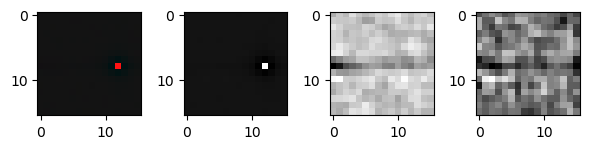

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 6))
img = filters[140]
img = (img - img.min()) / (img.max() - img.min())


axes[0].imshow(img.permute(1,2,0))

axes[1].imshow(img[0], cmap='gray')
axes[2].imshow(img[1], cmap='gray')
axes[3].imshow(img[2], cmap='gray')

# Adjust layout
plt.tight_layout()
plt.show()